# Data analysis for the research "OpenStreetMap Contribution to Local Data Ecosystems in COVID-19 Times: Experiences and Reflections from the Italian Case"

This interactive notebook contains information and code used for the analyses supporting the article "OpenStreetMap Contribution to Local Data Ecosystems in COVID-19 Times: Experiences and Reflections from the Italian Case", to be submitted to the Journal "[Data](https://www.mdpi.com/journal/data)" for inclusion in the special issue "[A European Approach to the Establishment of Data Spaces](https://www.mdpi.com/journal/data/special_issues/EU_DataSpaces)".

Authors:
- Marco Minghini - JRC
- Alessandro Saretta - CNR
- Maurizio Napolitano - FBK

The analyses cover data used for the production of tables and figures present in the section 4 of the article "_OpenStreetMap use cases to fight COVID-19 in Italy_" and are grouped here using the same enumeration and naming of the article to better allow linking between text and code:
* 4.1 Red zones
* 4.2 Pharmacies
* 4.3 Delivery services
* 4.4 Maps to visualise COVID-19-related information
* 4.5 Development/update of specific OSM tool


## Libraries needed
The analysis relies on the API of the [OHSOME project](https://heigit.org/big-spatial-data-analytics-en/ohsome/)

In [1]:
import geopandas as gpd
import os
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns
from ohsome import OhsomeClient
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="ticks", palette="pastel")

In [2]:
import folium
import mapclassify

### analyzes taken into account 

#### intervention by the Italian community in the first outbreak cities
The cities in question are those of [Codogno](https://www.openstreetmap.org/#map=14/45.1667/9.6793)(Lodi) and [Vo'](https://www.openstreetmap.org/#map=16/45.3305/11.6422)(Padua)<br/>
The analysis focuses on building data collection<br/>
The period under consideration taken into consideration the weeks from from 23 February to 7 March

#### data entry regarding pharmacies in Italy 
the Italian community has undertaken to update and correct the data with the positions of pharmacies in Italy starting from the [open data dataset of the italian ministry of health](https://www.dati.salute.gov.it/dati/dettaglioDataset.jsp?menu=dati&idPag=5)

#### insertion of delivery service keys created during lock-down
during the lockdown period many commercial activities activated for the delivery service and, from here, the international community took action by [bringing this data](https://wiki.openstreetmap.org/wiki/COVID-19_-_How_to_Map#Keys_delivery.2C_takeaway.2C_drive-through_services) to OpenStreetMap


## data setup
- borders of Codogno and Vo' (geojson created by the [shapefile](https://www.istat.it/storage/cartografia/confini_amministrativi/non_generalizzati/Limiti01012020.zip) of the [italian administrative boundaries](https://www.istat.it/it/archivio/222527) of ISTAT - Italian National Institute of Statistics)
- borders of Italy (geojson created by the [shapefile](https://www.istat.it/storage/cartografia/confini_amministrativi/non_generalizzati/Limiti01012020.zip) of the [italian administrative boundaries](https://www.istat.it/it/archivio/222527) of ISTAT - Italian National Institute of Statistics)

The data of ISTAT is distributed under the CC-BY license<br/>
The data extract from OHSOME is under the ODbL license



### time periods

In [3]:
time_weaks_2020 =  "{}/{}/P1W".format("2020-01-01", "2020-12-31")
time_months_2020 =  "{}/{}/P1W".format("2020-01-01", "2020-12-31")
time_daily_february_march_2020 =  "{}/{}/P1D".format("2020-02-23", "2020-03-07")
time_weeks_february_june_2020 =  "{}/{}/P1W".format("2020-02-01", "2020-06-30")


### geodata (borders)

In [4]:
borders_codogno=gpd.read_file("data" + os.sep + "borders" + os.sep + "codogno.geojson")
borders_vo=gpd.read_file("data" + os.sep + "borders" + os.sep + "vo.geojson")
borders_italy = gpd.read_file("data" + os.sep + "borders" + os.sep + "italy.geojson")

#### show the borders on a map
*Codogno*

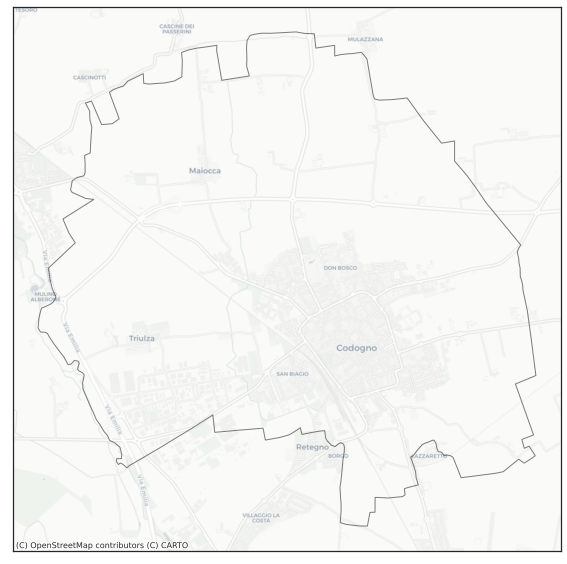

In [5]:
ax = borders_codogno.to_crs(epsg=3857).plot(figsize=(10, 10), facecolor="none",alpha=0.5, edgecolor='black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)

In [6]:
borders_codogno.explore()

AttributeError: 'GeoDataFrame' object has no attribute 'explore'

*Vo'*

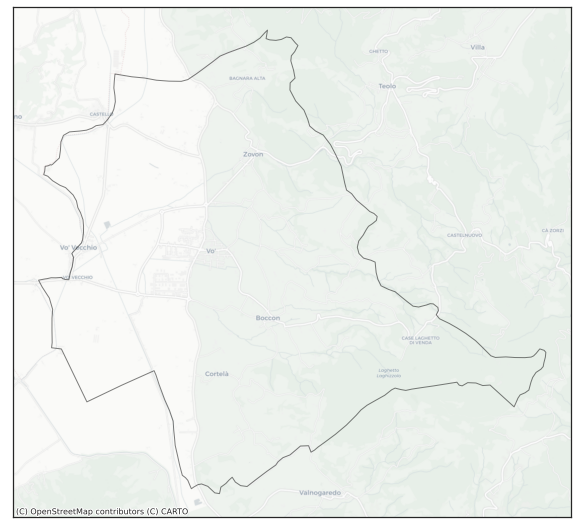

In [7]:
ax = borders_vo.to_crs(epsg=3857).plot(figsize=(10, 10), facecolor="none",alpha=0.5, edgecolor='black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)

In [8]:
borders_vo.explore()

AttributeError: 'GeoDataFrame' object has no attribute 'explore'

*Italy*

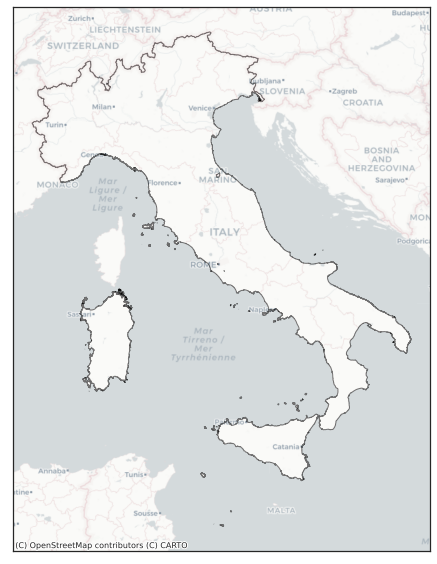

In [9]:
ax = borders_italy.to_crs(epsg=3857).plot(figsize=(10, 10), facecolor="none",alpha=0.5, edgecolor='black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)

In [10]:
borders_italy.explore()

AttributeError: 'GeoDataFrame' object has no attribute 'explore'

## Data Extraction
the extraction is based on [OHSOME api](https://heigit.org/big-spatial-data-analytics-en/ohsome/)

In [11]:
client = OhsomeClient()

### intervention by the Italian community in the first outbreak cities

The two cities taken into consideration are Codogno and Vo ': the first Italian outbreaks where the government has begun the first interventions.

In the specific case it was decided to identify the contribution of the community in the creation of the buildings

In [12]:
tags = ["building=*"]

#### Buildings in Codogno

In [13]:
%%time
data = []
for tag in tags:
    response = client.elements.count.groupByBoundary.post(
        bpolys=borders_codogno.geometry.to_json(),
        time=time_daily_february_march_2020,
        filter="{} and (type:relation or type:way) and geometry:polygon".format(tag))
    data.append(response.as_dataframe().rename(columns={"value":tag}))
buildings_codogno = pd.concat(data, axis=1)

CPU times: user 29.9 ms, sys: 1.41 ms, total: 31.3 ms
Wall time: 52.6 s


In [14]:
buildings_codogno.head(10)

building=*
boundary timestamp                            
0        2020-02-23 00:00:00+00:00       302.0
         2020-02-24 00:00:00+00:00       302.0
         2020-02-25 00:00:00+00:00      1152.0
         2020-02-26 00:00:00+00:00      1256.0
         2020-02-27 00:00:00+00:00      5790.0
         2020-02-28 00:00:00+00:00      5803.0
         2020-02-29 00:00:00+00:00      5846.0
         2020-03-01 00:00:00+00:00      5846.0
         2020-03-02 00:00:00+00:00      5846.0
         2020-03-03 00:00:00+00:00      5846.0

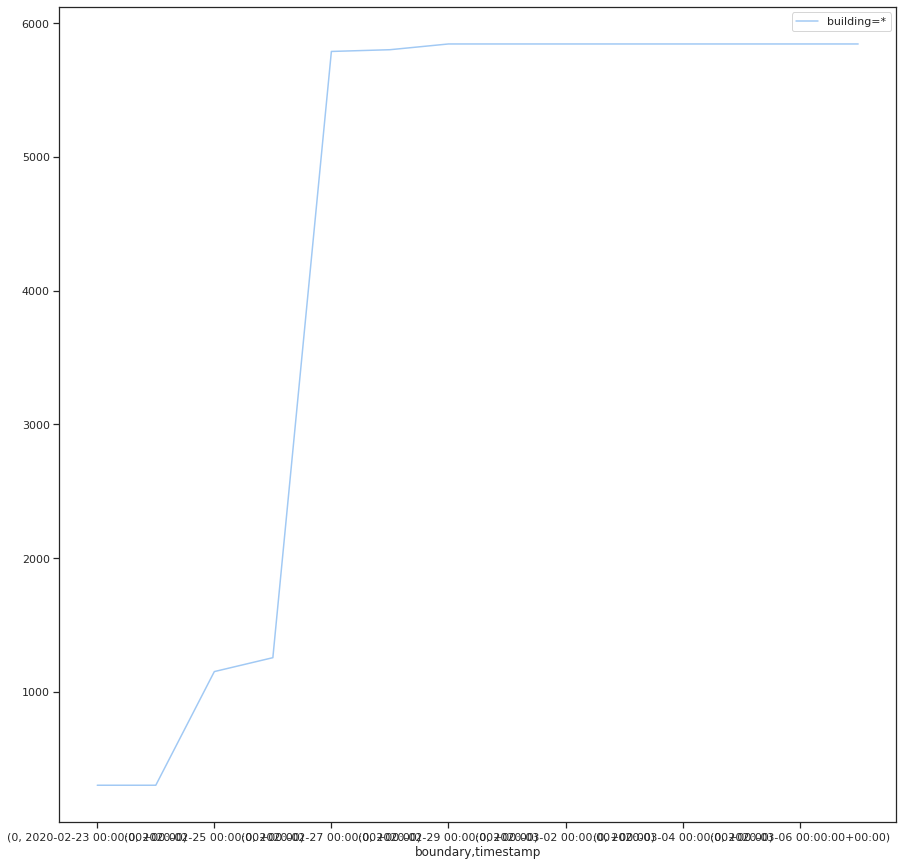

In [15]:
buildings_codogno.plot(figsize=(15,15))
plt.show()

In [16]:
print("The total number of buildings before Codogno became a hotbed (2020-02-15) city is " + str(int(buildings_codogno['building=*'].min())))
print("The total number of buildings after Codogno became a hotbed (2020-02-15) city is " + str(int(buildings_codogno['building=*'].max())))

The total number of buildings before Codogno became a hotbed (2020-02-15) city is 302
The total number of buildings after Codogno became a hotbed (2020-02-15) city is 5846


In [17]:
# organize the data to create the csv file
buildings_codogno.reset_index(inplace=True)
buildings_codogno.rename(columns={'building=*':'total_building'}, inplace=True)
del buildings_codogno['boundary']
buildings_codogno.total_building = buildings_codogno.total_building.astype(int)

In [18]:
buildings_codogno.timestamp = buildings_codogno.timestamp.astype(str)
buildings_codogno.timestamp = buildings_codogno.timestamp.apply(lambda x: x.replace(" 00:00:00+00:00",""))

In [19]:
# save file
buildings_codogno.to_csv("data" + os.sep + "buildings_codogno.csv", index=False)

#### Buildings in Vo'

In [20]:
%%time
data = []
for tag in tags:
    response = client.elements.count.groupByBoundary.post(
        bpolys=borders_vo.geometry.to_json(),
        time=time_daily_february_march_2020,
        filter="{} and (type:relation or type:way) and geometry:polygon".format(tag))
    data.append(response.as_dataframe().rename(columns={"value":tag}))
buildings_vo = pd.concat(data, axis=1)

CPU times: user 21.4 ms, sys: 1.32 ms, total: 22.8 ms
Wall time: 7.49 s


In [21]:
buildings_vo.head(10)

building=*
boundary timestamp                            
0        2020-02-23 00:00:00+00:00      2584.0
         2020-02-24 00:00:00+00:00      2584.0
         2020-02-25 00:00:00+00:00      2598.0
         2020-02-26 00:00:00+00:00      2598.0
         2020-02-27 00:00:00+00:00      2598.0
         2020-02-28 00:00:00+00:00      2598.0
         2020-02-29 00:00:00+00:00      2598.0
         2020-03-01 00:00:00+00:00      2598.0
         2020-03-02 00:00:00+00:00      2598.0
         2020-03-03 00:00:00+00:00      2598.0

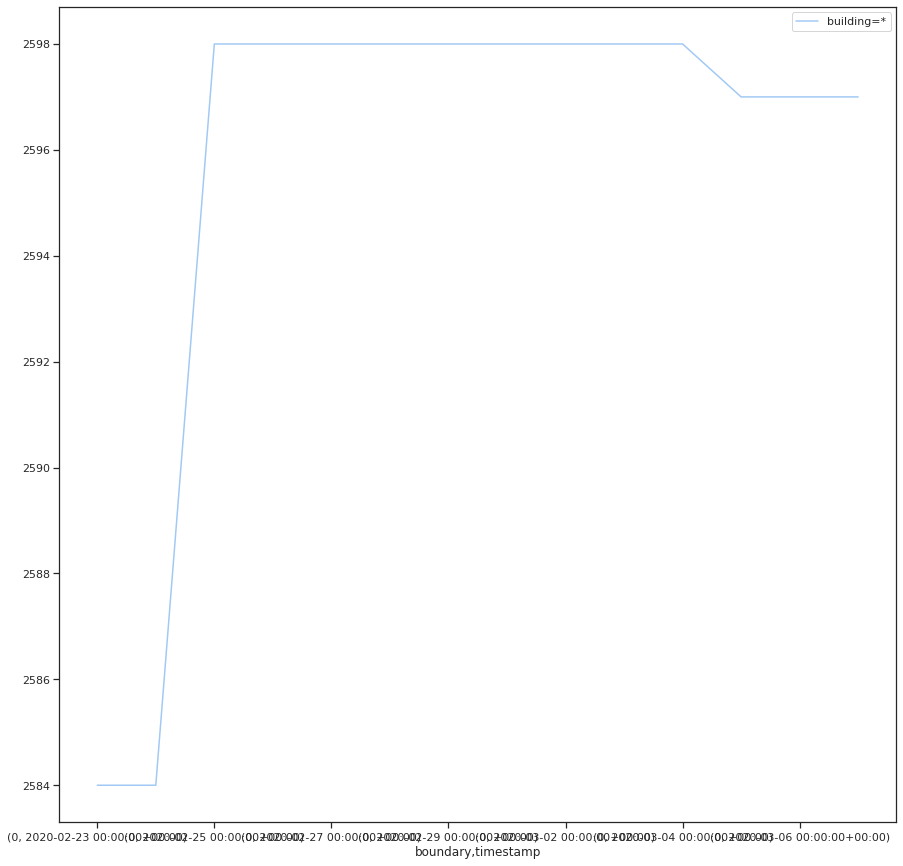

In [22]:
buildings_vo.plot(figsize=(15,15))
plt.show()

In [23]:
print("The total number of buildings BEFORE Vo' became a hotbed (2020-02-15) city is " + str(int(buildings_vo['building=*'].min())))
print("The total number of buildings AFTER Vo' became a hotbed (2020-02-15) city is " + str(int(buildings_vo['building=*'].max())))

The total number of buildings BEFORE Vo' became a hotbed (2020-02-15) city is 2584
The total number of buildings AFTER Vo' became a hotbed (2020-02-15) city is 2598


In [24]:
# organize the data to crfeate a csv fle
buildings_vo.reset_index(inplace=True)
buildings_vo.rename(columns={'building=*':'total_building'}, inplace=True)
del buildings_vo['boundary']
buildings_vo.total_building = buildings_vo.total_building.astype(int)

In [25]:
buildings_vo.timestamp = buildings_vo.timestamp.astype(str)
buildings_vo.timestamp = buildings_vo.timestamp.apply(lambda x: x.replace(" 00:00:00+00:00",""))

In [26]:
# save file
buildings_vo.to_csv("data" + os.sep + "buildings_vo.csv", index=False)

## data entry regarding pharmacies in Italy 

### all the weaks from february to june 2020

In [27]:
%%time
pharmacy_february_june = client.elements.count.groupByBoundary.post(
    bpolys=borders_italy.geometry.to_json(), 
    filter="amenity=pharmacy",
    time=time_weeks_february_june_2020
)

CPU times: user 1.29 s, sys: 106 ms, total: 1.39 s
Wall time: 3min 28s


In [28]:
pharmacy_february_june_df = pharmacy_february_june.as_dataframe()
pharmacy_february_june_df.head(10)

value
boundary timestamp                         
0        2020-02-01 00:00:00+00:00  10942.0
         2020-02-08 00:00:00+00:00  10955.0
         2020-02-15 00:00:00+00:00  10958.0
         2020-02-22 00:00:00+00:00  10974.0
         2020-02-29 00:00:00+00:00  10989.0
         2020-03-07 00:00:00+00:00  10999.0
         2020-03-14 00:00:00+00:00  11022.0
         2020-03-21 00:00:00+00:00  11132.0
         2020-03-28 00:00:00+00:00  11283.0
         2020-04-04 00:00:00+00:00  11332.0

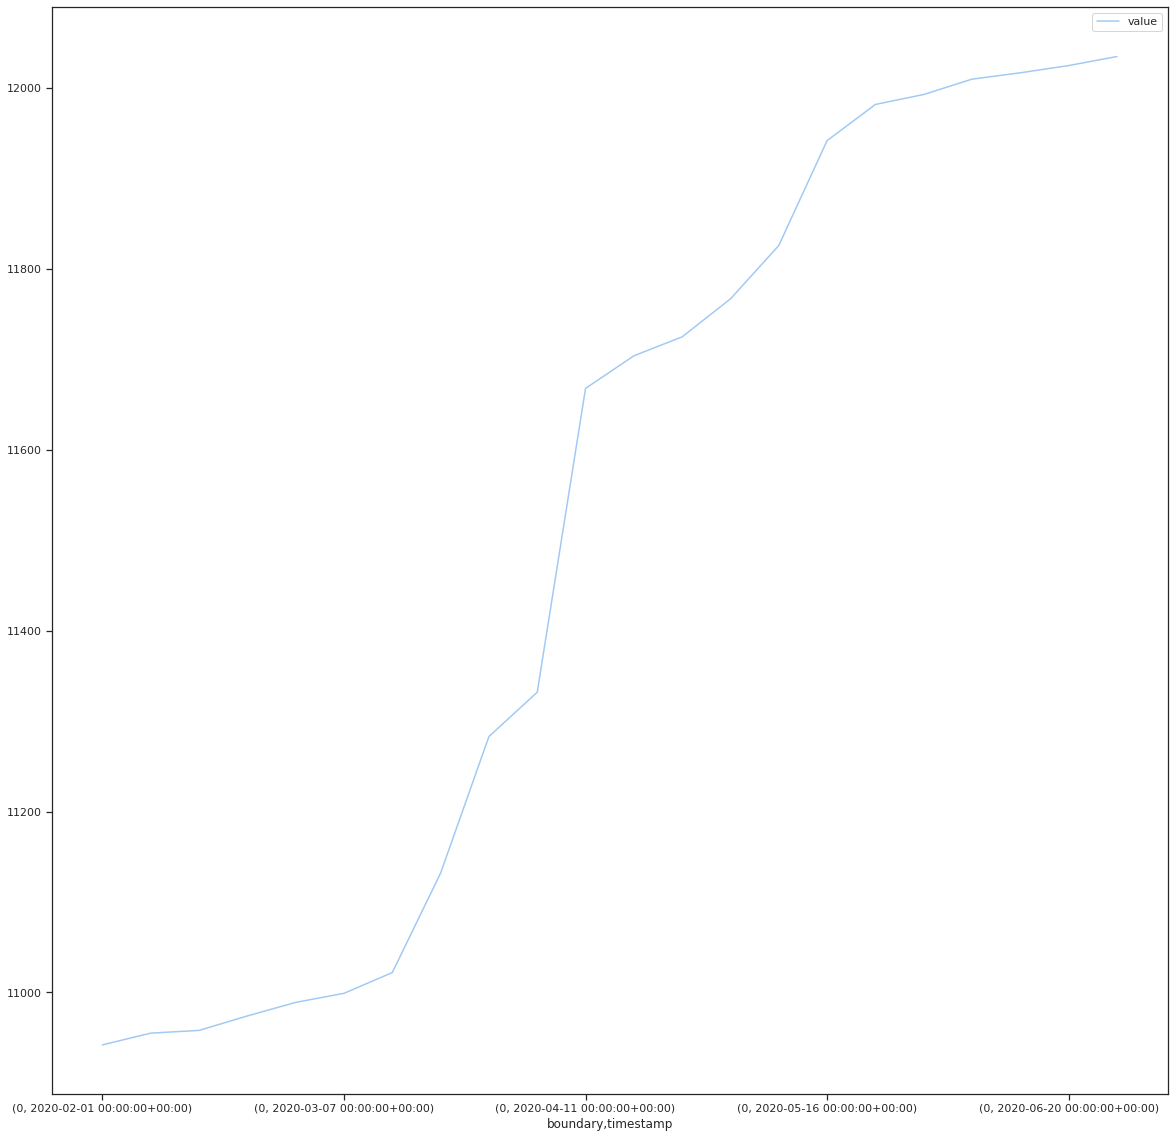

In [29]:
pharmacy_february_june_df.plot(figsize=(20,20))
plt.show()

In [30]:
pharmacy_february_june_df.reset_index(inplace=True)
pharmacy_february_june_df['value'] = pharmacy_february_june_df.value.astype(int)
pharmacy_february_june_df.rename(columns={"value":"pharmacies"}, inplace=True)

In [31]:
del pharmacy_february_june_df['boundary']

In [32]:
pharmacy_february_june_df.timestamp = pharmacy_february_june_df.timestamp.astype(str)
pharmacy_february_june_df.timestamp = pharmacy_february_june_df.timestamp.apply(lambda x: x.replace(" 00:00:00+00:00",""))

In [33]:
# save the file
pharmacy_february_june_df.to_csv("data" + os.sep + "phamarcies_data_inserted_italy_february_june_2020.csv",index=False)

### all the weaks of 2020

In [34]:
%%time
pharmacy = client.elements.count.groupByBoundary.post(
    bpolys=borders_italy.geometry.to_json(), 
    filter="amenity=pharmacy",
    time=time_weaks_2020)

CPU times: user 1.35 s, sys: 55.8 ms, total: 1.41 s
Wall time: 3min 18s


In [35]:
pharmacy_df = pharmacy.as_dataframe()

In [36]:
pharmacy_df.head(10)

value
boundary timestamp                         
0        2020-01-01 00:00:00+00:00  10862.0
         2020-01-08 00:00:00+00:00  10884.0
         2020-01-15 00:00:00+00:00  10896.0
         2020-01-22 00:00:00+00:00  10913.0
         2020-01-29 00:00:00+00:00  10928.0
         2020-02-05 00:00:00+00:00  10948.0
         2020-02-12 00:00:00+00:00  10955.0
         2020-02-19 00:00:00+00:00  10963.0
         2020-02-26 00:00:00+00:00  10988.0
         2020-03-04 00:00:00+00:00  10998.0

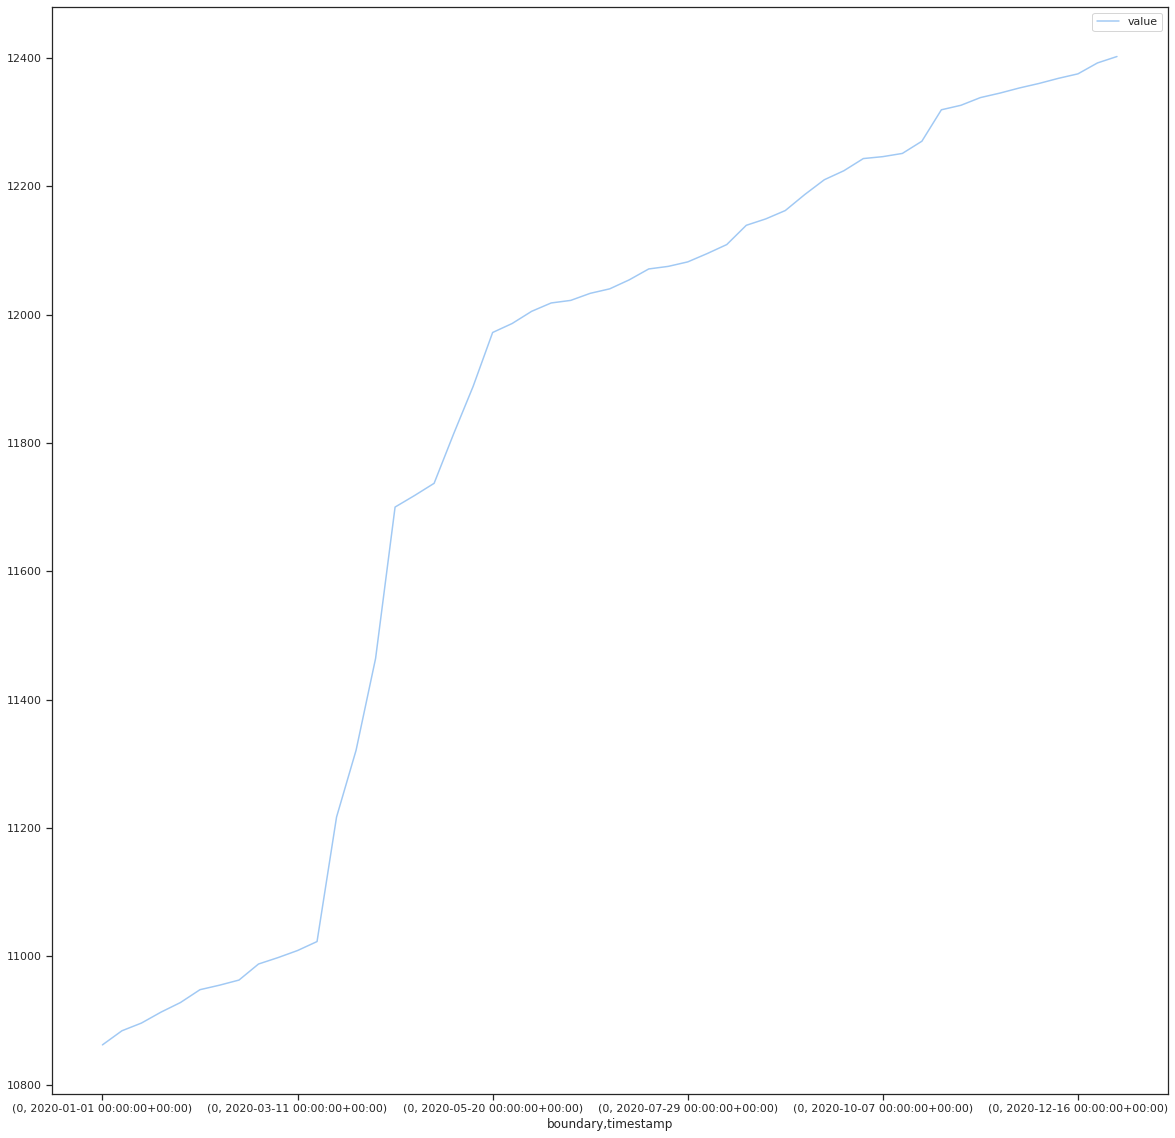

In [37]:
pharmacy_df.plot(figsize=(20,20))
plt.show()

In [38]:
pharmacy_df.reset_index(inplace=True)
pharmacy_df['value'] = pharmacy_df.value.astype(int)
pharmacy_df.rename(columns={"value":"pharmacies"}, inplace=True)
del pharmacy_df['boundary']
pharmacy_df.timestamp = pharmacy_df.timestamp.astype(str)
pharmacy_df.timestamp = pharmacy_df.timestamp.str.replace(" 00:00:00+00:00","")
pharmacy_df.timestamp = pharmacy_df.timestamp.apply(lambda x: x.replace(" 00:00:00+00:00",""))

In [39]:
# save the file
pharmacy_df.to_csv("data" + os.sep + "phamarcies_data_inserted_italy.csv",index=False)

## insertion of delivery service keys created during lock-down
all the tag like "*:covid19=*"


In [40]:
tags = ["delivery:covid19=*","opening_hours:covid19=*", "description:covid19=*","takeaway:covid19=*","access:covid19=*"]

In [41]:
%%time
data = []
for tag in tags:
    response = client.elements.count.groupByBoundary.post(
        bpolys=borders_italy.geometry.to_json(),
        time=time_weaks_2020,
        filter="{}".format(tag))
    data.append(response.as_dataframe().rename(columns={"value":tag}))
covid_delivery = pd.concat(data, axis=1)

CPU times: user 6.46 s, sys: 469 ms, total: 6.93 s
Wall time: 19min 16s


In [42]:
covid_delivery.head(10)

delivery:covid19=*  \
boundary timestamp                                       
0        2020-01-01 00:00:00+00:00                 0.0   
         2020-01-08 00:00:00+00:00                 0.0   
         2020-01-15 00:00:00+00:00                 0.0   
         2020-01-22 00:00:00+00:00                 0.0   
         2020-01-29 00:00:00+00:00                 0.0   
         2020-02-05 00:00:00+00:00                 0.0   
         2020-02-12 00:00:00+00:00                 0.0   
         2020-02-19 00:00:00+00:00                 0.0   
         2020-02-26 00:00:00+00:00                 0.0   
         2020-03-04 00:00:00+00:00                 0.0   

                                    opening_hours:covid19=*  \
boundary timestamp                                            
0        2020-01-01 00:00:00+00:00                      0.0   
         2020-01-08 00:00:00+00:00                      0.0   
         2020-01-15 00:00:00+00:00                      0.0   
         2020-01-22 00:00:00+00:00                      0.0   
         2020-01-29 00:00:00+00:00                      0.0   
         2020-02-05 00:00:00+00:00                      0.0   
         2020-02-12 00:00:00+00:00                      0.0   
         2020-02-19 00:00:00+00:00                      0.0   
         2020-02-26 00:00:00+00:00                      0.0   
         2020-03-04 00:00:00+00:00                      0.0   

                                    description:covid19=*  takeaway:covid19=*  \
boundary timestamp                                                              
0        2020-01-01 00:00:00+00:00                    0.0                 0.0   
         2020-01-08 00:00:00+00:00                    0.0                 0.0   
         2020-01-15 00:00:00+00:00                    0.0                 0.0   
         2020-01-22 00:00:00+00:00                    0.0                 0.0   
         2020-01-29 00:00:00+00:00                    0.0                 0.0   
         2020-02-05 00:00:00+00:00                    0.0                 0.0   
         2020-02-12 00:00:00+00:00                    0.0                 0.0   
         2020-02-19 00:00:00+00:00                    0.0                 0.0   
         2020-02-26 00:00:00+00:00                    0.0                 0.0   
         2020-03-04 00:00:00+00:00                    0.0                 0.0   

                                    access:covid19=*  
boundary timestamp                                    
0        2020-01-01 00:00:00+00:00               0.0  
         2020-01-08 00:00:00+00:00               0.0  
         2020-01-15 00:00:00+00:00               0.0  
         2020-01-22 00:00:00+00:00               0.0  
         2020-01-29 00:00:00+00:00               0.0  
         2020-02-05 00:00:00+00:00               0.0  
         2020-02-12 00:00:00+00:00               0.0  
         2020-02-19 00:00:00+00:00               0.0  
         2020-02-26 00:00:00+00:00               0.0  
         2020-03-04 00:00:00+00:00               0.0

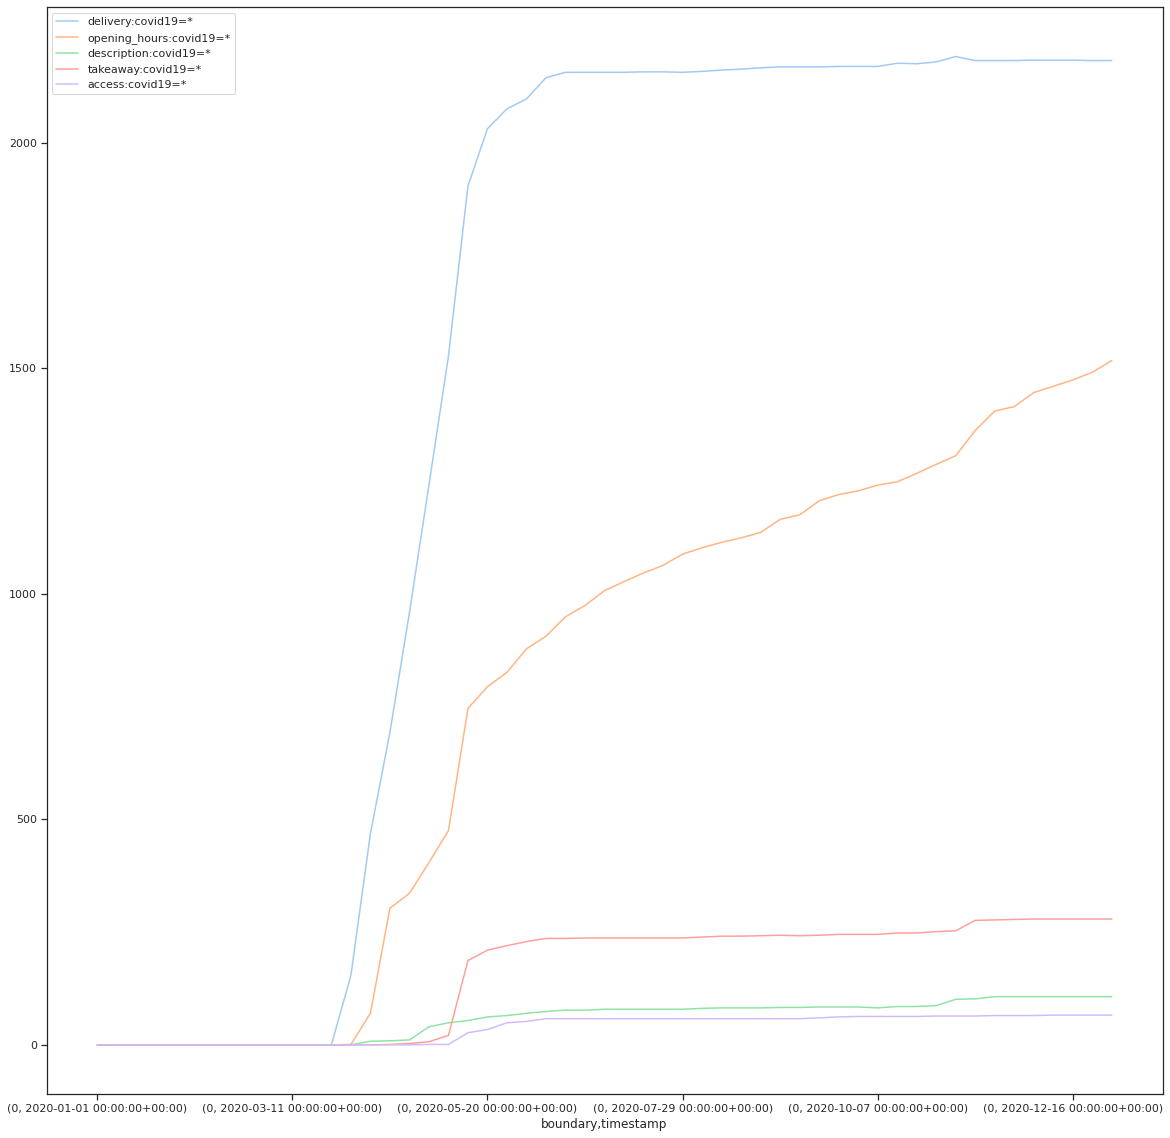

In [43]:
covid_delivery.plot(figsize=(20,20))
plt.show()

In [44]:
covid_delivery.reset_index(inplace=True)

In [45]:
covid_delivery.rename(columns={
    "delivery:covid19=*":"delivery",
    "opening_hours:covid19=*":"opening_hours",
    "description:covid19=*":"description",
    "takeaway:covid19=*":"takeway",
    "access:covid19=*":"access"}, inplace=True)

In [46]:
del covid_delivery['boundary']

In [47]:
covid_delivery.delivery = covid_delivery.delivery.astype(int)
covid_delivery.opening_hours = covid_delivery.opening_hours.astype(int)
covid_delivery.description = covid_delivery.description.astype(int)
covid_delivery.takeway = covid_delivery.takeway.astype(int)
covid_delivery.access = covid_delivery.access.astype(int)

In [48]:
covid_delivery.timestamp = covid_delivery.timestamp.astype(str)
covid_delivery.timestamp = covid_delivery   .timestamp.apply(lambda x: x.replace(" 00:00:00+00:00",""))

In [49]:
# save the file
covid_delivery.to_csv("data" + os.sep + "covid_tags_delivery_services_italy.csv",index=False)